# Import

In [1]:
!nvidia-smi

Thu Jan  7 00:50:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:01:00.0 Off |                  N/A |
|  0%   38C    P5    18W / 350W |    320MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import pandas as pd
import numpy as np
import glob
#import cupy as cp
import os
import gc
import time
import torch
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
print(torch.__version__)
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline
from janest_model import MLPNet , CustomDataset, train_model, autoencoder
from utils import PurgedGroupTimeSeriesSplit

1.7.1+cu110


In [ ]:
#%%writefile test.py
#print('hello world!')

## Parameter setting

In [2]:
TRAINING = True
USE_FINETUNE = True     
FOLDS = 5
GROUP_GAP = 20
SEED = 66
INPUTPATH = '../../input'
NUM_EPOCH = 500
BATCH_SIZE = 16384
PATIANCE = 15
LR = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
MDL_PATH  = '../models'
MDL_NAME = 'ae'
NUM_LYR = 5
VER = 'cv_base'

cuda


## Import Data 

In [18]:
%%time
train = pd.read_parquet(f'{INPUTPATH}/train.parquet')
f_mean = np.load( f'{INPUTPATH}/f_mean.npy')
X = np.load( f'{INPUTPATH}/X.npy')
y = np.load( f'{INPUTPATH}/y.npy')
test_df = pd.read_csv(f'{INPUTPATH}/example_test.csv')
pred_df  = pd.read_csv(f'{INPUTPATH}/example_sample_submission.csv')

CPU times: user 8.27 s, sys: 5.26 s, total: 13.5 s
Wall time: 9.81 s


# Features

In [6]:
print(X.shape[-1])
print(y.shape[-1])

130
5


# Trainning

## Data Split

In [11]:
gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)

## Autoencoder

### CV 

In [28]:
#model = MLPNet(input_size = X.shape[-1], output_size = y.shape[-1]).to(DEVICE)
model = autoencoder(input_size = X.shape[-1], output_size = y.shape[-1], noise=0.1).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=5)

In [16]:
model

autoencoder(
  (encoder): Sequential(
    (0): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=130, out_features=640, bias=True)
    (2): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=640, out_features=130, bias=True)
  )
  (hidden): Linear(in_features=130, out_features=320, bias=True)
  (bat): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=320, out_features=5, bias=True)
  (act): Sigmoid()
)

Fold : 1


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.263465,         Valid BCE loss: 0.249854,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.258084,         Valid BCE loss: 0.249614,       Early stopping counter: 0
Epoch [3/500],        Train BCE loss: 0.256034,         Valid BCE loss: 0.249413,       Early stopping counter: 0
Epoch [4/500],        Train BCE loss: 0.254771,         Valid BCE loss: 0.249385,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.253984,         Valid BCE loss: 0.249275,       Early stopping counter: 0
Epoch [6/500],        Train BCE loss: 0.253499,         Valid BCE loss: 0.249198,       Early stopping counter: 0
Epoch [7/500],        Train BCE loss: 0.252946,         Valid BCE loss: 0.249122,       Early stopping counter: 0
Epoch [8/500],        Train BCE loss: 0.252687,         Valid BCE loss: 0.249065,       Early stopping counter: 0
Epoch [9/500],        Train BCE loss: 0.252317,         Valid BCE loss: 0.249030,       

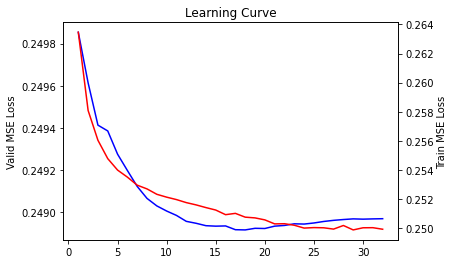

Fold : 2


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.251668,         Valid BCE loss: 0.249034,       Early stopping counter: 0
Epoch    35: reducing learning rate of group 0 to 1.0000e-07.
Epoch [2/500],        Train BCE loss: 0.251725,         Valid BCE loss: 0.249022,       Early stopping counter: 0
Epoch [3/500],        Train BCE loss: 0.251756,         Valid BCE loss: 0.249019,       Early stopping counter: 0
Epoch [4/500],        Train BCE loss: 0.251575,         Valid BCE loss: 0.249017,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.251591,         Valid BCE loss: 0.249016,       Early stopping counter: 0
Epoch [6/500],        Train BCE loss: 0.251700,         Valid BCE loss: 0.249015,       Early stopping counter: 0
Epoch [7/500],        Train BCE loss: 0.251703,         Valid BCE loss: 0.249014,       Early stopping counter: 0
Epoch    41: reducing learning rate of group 0 to 1.0000e-08.
Epoch [8/500],        Train BCE loss: 0.251661,         Valid BCE loss: 0.2490

Epoch [72/500],        Train BCE loss: 0.251612,         Valid BCE loss: 0.249004,       Early stopping counter: 1
Epoch [73/500],        Train BCE loss: 0.251649,         Valid BCE loss: 0.249004,       Early stopping counter: 2
Epoch [74/500],        Train BCE loss: 0.251706,         Valid BCE loss: 0.249004,       Early stopping counter: 0
Epoch [75/500],        Train BCE loss: 0.251576,         Valid BCE loss: 0.249005,       Early stopping counter: 1
Epoch [76/500],        Train BCE loss: 0.251766,         Valid BCE loss: 0.249003,       Early stopping counter: 0
Epoch [77/500],        Train BCE loss: 0.251680,         Valid BCE loss: 0.249002,       Early stopping counter: 0
Epoch [78/500],        Train BCE loss: 0.251730,         Valid BCE loss: 0.249004,       Early stopping counter: 1
Epoch [79/500],        Train BCE loss: 0.251630,         Valid BCE loss: 0.249005,       Early stopping counter: 2
Epoch [80/500],        Train BCE loss: 0.251686,         Valid BCE loss: 0.24900

Epoch [143/500],        Train BCE loss: 0.251673,         Valid BCE loss: 0.248997,       Early stopping counter: 1
Epoch [144/500],        Train BCE loss: 0.251549,         Valid BCE loss: 0.248997,       Early stopping counter: 0
Epoch [145/500],        Train BCE loss: 0.251603,         Valid BCE loss: 0.248996,       Early stopping counter: 0
Epoch [146/500],        Train BCE loss: 0.251662,         Valid BCE loss: 0.248997,       Early stopping counter: 1
Epoch [147/500],        Train BCE loss: 0.251668,         Valid BCE loss: 0.248997,       Early stopping counter: 2
Epoch [148/500],        Train BCE loss: 0.251692,         Valid BCE loss: 0.248996,       Early stopping counter: 0
Epoch [149/500],        Train BCE loss: 0.251712,         Valid BCE loss: 0.248996,       Early stopping counter: 0
Epoch [150/500],        Train BCE loss: 0.251679,         Valid BCE loss: 0.248996,       Early stopping counter: 1
Epoch [151/500],        Train BCE loss: 0.251627,         Valid BCE loss

Epoch [214/500],        Train BCE loss: 0.251721,         Valid BCE loss: 0.248990,       Early stopping counter: 1
Epoch [215/500],        Train BCE loss: 0.251558,         Valid BCE loss: 0.248989,       Early stopping counter: 0
Epoch [216/500],        Train BCE loss: 0.251610,         Valid BCE loss: 0.248989,       Early stopping counter: 1
Epoch [217/500],        Train BCE loss: 0.251709,         Valid BCE loss: 0.248990,       Early stopping counter: 2
Epoch [218/500],        Train BCE loss: 0.251642,         Valid BCE loss: 0.248989,       Early stopping counter: 3
Epoch [219/500],        Train BCE loss: 0.251698,         Valid BCE loss: 0.248990,       Early stopping counter: 4
Epoch [220/500],        Train BCE loss: 0.251751,         Valid BCE loss: 0.248990,       Early stopping counter: 5
Epoch [221/500],        Train BCE loss: 0.251636,         Valid BCE loss: 0.248989,       Early stopping counter: 6
Epoch [222/500],        Train BCE loss: 0.251550,         Valid BCE loss

Epoch [285/500],        Train BCE loss: 0.251694,         Valid BCE loss: 0.248982,       Early stopping counter: 11
Epoch [286/500],        Train BCE loss: 0.251626,         Valid BCE loss: 0.248982,       Early stopping counter: 12
Epoch [287/500],        Train BCE loss: 0.251633,         Valid BCE loss: 0.248983,       Early stopping counter: 13
Epoch [288/500],        Train BCE loss: 0.251640,         Valid BCE loss: 0.248981,       Early stopping counter: 0
Epoch [289/500],        Train BCE loss: 0.251646,         Valid BCE loss: 0.248982,       Early stopping counter: 1
Epoch [290/500],        Train BCE loss: 0.251562,         Valid BCE loss: 0.248982,       Early stopping counter: 2
Epoch [291/500],        Train BCE loss: 0.251553,         Valid BCE loss: 0.248981,       Early stopping counter: 3
Epoch [292/500],        Train BCE loss: 0.251692,         Valid BCE loss: 0.248981,       Early stopping counter: 4
Epoch [293/500],        Train BCE loss: 0.251692,         Valid BCE l

Epoch [356/500],        Train BCE loss: 0.251606,         Valid BCE loss: 0.248975,       Early stopping counter: 2
Epoch [357/500],        Train BCE loss: 0.251644,         Valid BCE loss: 0.248975,       Early stopping counter: 3
Epoch [358/500],        Train BCE loss: 0.251640,         Valid BCE loss: 0.248976,       Early stopping counter: 4
Epoch [359/500],        Train BCE loss: 0.251658,         Valid BCE loss: 0.248974,       Early stopping counter: 0
Epoch [360/500],        Train BCE loss: 0.251622,         Valid BCE loss: 0.248975,       Early stopping counter: 1
Epoch [361/500],        Train BCE loss: 0.251621,         Valid BCE loss: 0.248976,       Early stopping counter: 2
Epoch [362/500],        Train BCE loss: 0.251715,         Valid BCE loss: 0.248975,       Early stopping counter: 3
Epoch [363/500],        Train BCE loss: 0.251576,         Valid BCE loss: 0.248975,       Early stopping counter: 4
Epoch [364/500],        Train BCE loss: 0.251774,         Valid BCE loss

Epoch [427/500],        Train BCE loss: 0.251678,         Valid BCE loss: 0.248969,       Early stopping counter: 7
Epoch [428/500],        Train BCE loss: 0.251577,         Valid BCE loss: 0.248968,       Early stopping counter: 0
Epoch [429/500],        Train BCE loss: 0.251615,         Valid BCE loss: 0.248968,       Early stopping counter: 1
Epoch [430/500],        Train BCE loss: 0.251710,         Valid BCE loss: 0.248969,       Early stopping counter: 2
Epoch [431/500],        Train BCE loss: 0.251675,         Valid BCE loss: 0.248969,       Early stopping counter: 3
Epoch [432/500],        Train BCE loss: 0.251569,         Valid BCE loss: 0.248969,       Early stopping counter: 4
Epoch [433/500],        Train BCE loss: 0.251629,         Valid BCE loss: 0.248970,       Early stopping counter: 5
Epoch [434/500],        Train BCE loss: 0.251565,         Valid BCE loss: 0.248969,       Early stopping counter: 6
Epoch [435/500],        Train BCE loss: 0.251666,         Valid BCE loss

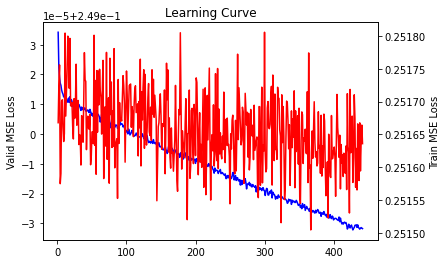

Fold : 3


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.251985,         Valid BCE loss: 0.248735,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.252019,         Valid BCE loss: 0.248735,       Early stopping counter: 0
Epoch [3/500],        Train BCE loss: 0.252010,         Valid BCE loss: 0.248736,       Early stopping counter: 1
Epoch [4/500],        Train BCE loss: 0.252026,         Valid BCE loss: 0.248735,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.252048,         Valid BCE loss: 0.248735,       Early stopping counter: 0
Epoch [6/500],        Train BCE loss: 0.251997,         Valid BCE loss: 0.248734,       Early stopping counter: 0
Epoch [7/500],        Train BCE loss: 0.251977,         Valid BCE loss: 0.248734,       Early stopping counter: 1
Epoch [8/500],        Train BCE loss: 0.252003,         Valid BCE loss: 0.248735,       Early stopping counter: 2
Epoch [9/500],        Train BCE loss: 0.251993,         Valid BCE loss: 0.248734,       

Epoch [73/500],        Train BCE loss: 0.252061,         Valid BCE loss: 0.248723,       Early stopping counter: 2
Epoch [74/500],        Train BCE loss: 0.251963,         Valid BCE loss: 0.248724,       Early stopping counter: 3
Epoch [75/500],        Train BCE loss: 0.251961,         Valid BCE loss: 0.248723,       Early stopping counter: 4
Epoch [76/500],        Train BCE loss: 0.252022,         Valid BCE loss: 0.248723,       Early stopping counter: 5
Epoch [77/500],        Train BCE loss: 0.251995,         Valid BCE loss: 0.248722,       Early stopping counter: 0
Epoch [78/500],        Train BCE loss: 0.252006,         Valid BCE loss: 0.248722,       Early stopping counter: 0
Epoch [79/500],        Train BCE loss: 0.252024,         Valid BCE loss: 0.248723,       Early stopping counter: 1
Epoch [80/500],        Train BCE loss: 0.252057,         Valid BCE loss: 0.248722,       Early stopping counter: 2
Epoch [81/500],        Train BCE loss: 0.251972,         Valid BCE loss: 0.24872

Epoch [144/500],        Train BCE loss: 0.251931,         Valid BCE loss: 0.248712,       Early stopping counter: 0
Epoch [145/500],        Train BCE loss: 0.251887,         Valid BCE loss: 0.248713,       Early stopping counter: 1
Epoch [146/500],        Train BCE loss: 0.251968,         Valid BCE loss: 0.248713,       Early stopping counter: 2
Epoch [147/500],        Train BCE loss: 0.251935,         Valid BCE loss: 0.248713,       Early stopping counter: 3
Epoch [148/500],        Train BCE loss: 0.251920,         Valid BCE loss: 0.248713,       Early stopping counter: 4
Epoch [149/500],        Train BCE loss: 0.251974,         Valid BCE loss: 0.248712,       Early stopping counter: 5
Epoch [150/500],        Train BCE loss: 0.251894,         Valid BCE loss: 0.248712,       Early stopping counter: 0
Epoch [151/500],        Train BCE loss: 0.251904,         Valid BCE loss: 0.248712,       Early stopping counter: 1
Epoch [152/500],        Train BCE loss: 0.251939,         Valid BCE loss

Epoch [215/500],        Train BCE loss: 0.251983,         Valid BCE loss: 0.248703,       Early stopping counter: 3
Epoch [216/500],        Train BCE loss: 0.251930,         Valid BCE loss: 0.248703,       Early stopping counter: 0
Epoch [217/500],        Train BCE loss: 0.251934,         Valid BCE loss: 0.248703,       Early stopping counter: 1
Epoch [218/500],        Train BCE loss: 0.251936,         Valid BCE loss: 0.248704,       Early stopping counter: 2
Epoch [219/500],        Train BCE loss: 0.251922,         Valid BCE loss: 0.248702,       Early stopping counter: 0
Epoch [220/500],        Train BCE loss: 0.251960,         Valid BCE loss: 0.248702,       Early stopping counter: 0
Epoch [221/500],        Train BCE loss: 0.251944,         Valid BCE loss: 0.248702,       Early stopping counter: 0
Epoch [222/500],        Train BCE loss: 0.251977,         Valid BCE loss: 0.248703,       Early stopping counter: 1
Epoch [223/500],        Train BCE loss: 0.251908,         Valid BCE loss

Epoch [286/500],        Train BCE loss: 0.251925,         Valid BCE loss: 0.248695,       Early stopping counter: 4
Epoch [287/500],        Train BCE loss: 0.251912,         Valid BCE loss: 0.248694,       Early stopping counter: 0
Epoch [288/500],        Train BCE loss: 0.251924,         Valid BCE loss: 0.248695,       Early stopping counter: 1
Epoch [289/500],        Train BCE loss: 0.251894,         Valid BCE loss: 0.248695,       Early stopping counter: 2
Epoch [290/500],        Train BCE loss: 0.251909,         Valid BCE loss: 0.248694,       Early stopping counter: 0
Epoch [291/500],        Train BCE loss: 0.251886,         Valid BCE loss: 0.248694,       Early stopping counter: 0
Epoch [292/500],        Train BCE loss: 0.251883,         Valid BCE loss: 0.248694,       Early stopping counter: 0
Epoch [293/500],        Train BCE loss: 0.251937,         Valid BCE loss: 0.248694,       Early stopping counter: 1
Epoch [294/500],        Train BCE loss: 0.251946,         Valid BCE loss

Epoch [357/500],        Train BCE loss: 0.251866,         Valid BCE loss: 0.248686,       Early stopping counter: 4
Epoch [358/500],        Train BCE loss: 0.251894,         Valid BCE loss: 0.248687,       Early stopping counter: 5
Epoch [359/500],        Train BCE loss: 0.251783,         Valid BCE loss: 0.248687,       Early stopping counter: 6
Epoch [360/500],        Train BCE loss: 0.251967,         Valid BCE loss: 0.248686,       Early stopping counter: 7
Epoch [361/500],        Train BCE loss: 0.251978,         Valid BCE loss: 0.248686,       Early stopping counter: 8
Epoch [362/500],        Train BCE loss: 0.251884,         Valid BCE loss: 0.248687,       Early stopping counter: 9
Epoch [363/500],        Train BCE loss: 0.251860,         Valid BCE loss: 0.248686,       Early stopping counter: 10
Epoch [364/500],        Train BCE loss: 0.251909,         Valid BCE loss: 0.248685,       Early stopping counter: 0
Epoch [365/500],        Train BCE loss: 0.251919,         Valid BCE los

Epoch [428/500],        Train BCE loss: 0.251825,         Valid BCE loss: 0.248680,       Early stopping counter: 6
Epoch [429/500],        Train BCE loss: 0.251974,         Valid BCE loss: 0.248678,       Early stopping counter: 0
Epoch [430/500],        Train BCE loss: 0.251861,         Valid BCE loss: 0.248678,       Early stopping counter: 0
Epoch [431/500],        Train BCE loss: 0.251898,         Valid BCE loss: 0.248679,       Early stopping counter: 1
Epoch [432/500],        Train BCE loss: 0.251943,         Valid BCE loss: 0.248677,       Early stopping counter: 0
Epoch [433/500],        Train BCE loss: 0.251842,         Valid BCE loss: 0.248679,       Early stopping counter: 1
Epoch [434/500],        Train BCE loss: 0.251857,         Valid BCE loss: 0.248677,       Early stopping counter: 2
Epoch [435/500],        Train BCE loss: 0.251902,         Valid BCE loss: 0.248678,       Early stopping counter: 3
Epoch [436/500],        Train BCE loss: 0.251874,         Valid BCE loss

Epoch [499/500],        Train BCE loss: 0.251868,         Valid BCE loss: 0.248673,       Early stopping counter: 7
Epoch [500/500],        Train BCE loss: 0.251862,         Valid BCE loss: 0.248671,       Early stopping counter: 0
The best bse loss is 0.248671


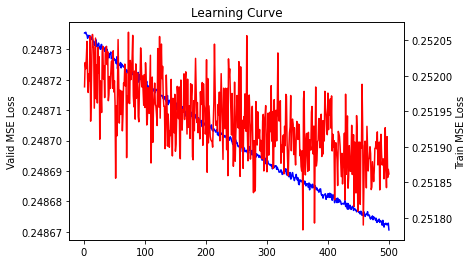

Fold : 4


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.252137,         Valid BCE loss: 0.249546,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.252099,         Valid BCE loss: 0.249546,       Early stopping counter: 1
Epoch [3/500],        Train BCE loss: 0.252076,         Valid BCE loss: 0.249546,       Early stopping counter: 2
Epoch [4/500],        Train BCE loss: 0.252153,         Valid BCE loss: 0.249541,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.252093,         Valid BCE loss: 0.249545,       Early stopping counter: 1
Epoch [6/500],        Train BCE loss: 0.252033,         Valid BCE loss: 0.249542,       Early stopping counter: 2
Epoch [7/500],        Train BCE loss: 0.252101,         Valid BCE loss: 0.249545,       Early stopping counter: 3
Epoch [8/500],        Train BCE loss: 0.252032,         Valid BCE loss: 0.249545,       Early stopping counter: 4
Epoch [9/500],        Train BCE loss: 0.252056,         Valid BCE loss: 0.249544,       

Epoch [73/500],        Train BCE loss: 0.252086,         Valid BCE loss: 0.249527,       Early stopping counter: 3
Epoch [74/500],        Train BCE loss: 0.252087,         Valid BCE loss: 0.249531,       Early stopping counter: 4
Epoch [75/500],        Train BCE loss: 0.252075,         Valid BCE loss: 0.249529,       Early stopping counter: 5
Epoch [76/500],        Train BCE loss: 0.252055,         Valid BCE loss: 0.249528,       Early stopping counter: 6
Epoch [77/500],        Train BCE loss: 0.252018,         Valid BCE loss: 0.249529,       Early stopping counter: 7
Epoch [78/500],        Train BCE loss: 0.252059,         Valid BCE loss: 0.249529,       Early stopping counter: 8
Epoch [79/500],        Train BCE loss: 0.252076,         Valid BCE loss: 0.249527,       Early stopping counter: 0
Epoch [80/500],        Train BCE loss: 0.252067,         Valid BCE loss: 0.249529,       Early stopping counter: 1
Epoch [81/500],        Train BCE loss: 0.252021,         Valid BCE loss: 0.24952

Epoch [144/500],        Train BCE loss: 0.252061,         Valid BCE loss: 0.249515,       Early stopping counter: 1
Epoch [145/500],        Train BCE loss: 0.252025,         Valid BCE loss: 0.249514,       Early stopping counter: 2
Epoch [146/500],        Train BCE loss: 0.252047,         Valid BCE loss: 0.249513,       Early stopping counter: 3
Epoch [147/500],        Train BCE loss: 0.252061,         Valid BCE loss: 0.249514,       Early stopping counter: 4
Epoch [148/500],        Train BCE loss: 0.252038,         Valid BCE loss: 0.249515,       Early stopping counter: 5
Epoch [149/500],        Train BCE loss: 0.252059,         Valid BCE loss: 0.249510,       Early stopping counter: 0
Epoch [150/500],        Train BCE loss: 0.252056,         Valid BCE loss: 0.249512,       Early stopping counter: 1
Epoch [151/500],        Train BCE loss: 0.252030,         Valid BCE loss: 0.249513,       Early stopping counter: 2
Epoch [152/500],        Train BCE loss: 0.252060,         Valid BCE loss

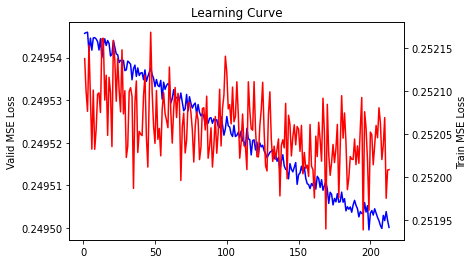

Fold : 5


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.252207,         Valid BCE loss: 0.248557,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.252212,         Valid BCE loss: 0.248558,       Early stopping counter: 1
Epoch [3/500],        Train BCE loss: 0.252236,         Valid BCE loss: 0.248556,       Early stopping counter: 0
Epoch [4/500],        Train BCE loss: 0.252185,         Valid BCE loss: 0.248557,       Early stopping counter: 1
Epoch [5/500],        Train BCE loss: 0.252257,         Valid BCE loss: 0.248558,       Early stopping counter: 2
Epoch [6/500],        Train BCE loss: 0.252231,         Valid BCE loss: 0.248556,       Early stopping counter: 0
Epoch [7/500],        Train BCE loss: 0.252141,         Valid BCE loss: 0.248557,       Early stopping counter: 1
Epoch [8/500],        Train BCE loss: 0.252140,         Valid BCE loss: 0.248556,       Early stopping counter: 2
Epoch [9/500],        Train BCE loss: 0.252200,         Valid BCE loss: 0.248555,       

Epoch [73/500],        Train BCE loss: 0.252163,         Valid BCE loss: 0.248533,       Early stopping counter: 1
Epoch [74/500],        Train BCE loss: 0.252135,         Valid BCE loss: 0.248533,       Early stopping counter: 2
Epoch [75/500],        Train BCE loss: 0.252113,         Valid BCE loss: 0.248532,       Early stopping counter: 3
Epoch [76/500],        Train BCE loss: 0.252204,         Valid BCE loss: 0.248531,       Early stopping counter: 4
Epoch [77/500],        Train BCE loss: 0.252176,         Valid BCE loss: 0.248531,       Early stopping counter: 5
Epoch [78/500],        Train BCE loss: 0.252154,         Valid BCE loss: 0.248532,       Early stopping counter: 6
Epoch [79/500],        Train BCE loss: 0.252186,         Valid BCE loss: 0.248530,       Early stopping counter: 0
Epoch [80/500],        Train BCE loss: 0.252134,         Valid BCE loss: 0.248530,       Early stopping counter: 1
Epoch [81/500],        Train BCE loss: 0.252220,         Valid BCE loss: 0.24852

Epoch [144/500],        Train BCE loss: 0.252160,         Valid BCE loss: 0.248509,       Early stopping counter: 0
Epoch [145/500],        Train BCE loss: 0.252109,         Valid BCE loss: 0.248508,       Early stopping counter: 0
Epoch [146/500],        Train BCE loss: 0.252209,         Valid BCE loss: 0.248509,       Early stopping counter: 1
Epoch [147/500],        Train BCE loss: 0.252213,         Valid BCE loss: 0.248509,       Early stopping counter: 2
Epoch [148/500],        Train BCE loss: 0.252135,         Valid BCE loss: 0.248507,       Early stopping counter: 0
Epoch [149/500],        Train BCE loss: 0.252150,         Valid BCE loss: 0.248508,       Early stopping counter: 1
Epoch [150/500],        Train BCE loss: 0.252181,         Valid BCE loss: 0.248507,       Early stopping counter: 0
Epoch [151/500],        Train BCE loss: 0.252189,         Valid BCE loss: 0.248507,       Early stopping counter: 1
Epoch [152/500],        Train BCE loss: 0.252123,         Valid BCE loss

Epoch [215/500],        Train BCE loss: 0.252147,         Valid BCE loss: 0.248488,       Early stopping counter: 2
Epoch [216/500],        Train BCE loss: 0.252174,         Valid BCE loss: 0.248489,       Early stopping counter: 3
Epoch [217/500],        Train BCE loss: 0.252148,         Valid BCE loss: 0.248487,       Early stopping counter: 0
Epoch [218/500],        Train BCE loss: 0.252142,         Valid BCE loss: 0.248487,       Early stopping counter: 0
Epoch [219/500],        Train BCE loss: 0.252135,         Valid BCE loss: 0.248488,       Early stopping counter: 1
Epoch [220/500],        Train BCE loss: 0.252125,         Valid BCE loss: 0.248486,       Early stopping counter: 0
Epoch [221/500],        Train BCE loss: 0.252136,         Valid BCE loss: 0.248485,       Early stopping counter: 0
Epoch [222/500],        Train BCE loss: 0.252125,         Valid BCE loss: 0.248486,       Early stopping counter: 1
Epoch [223/500],        Train BCE loss: 0.252105,         Valid BCE loss

Epoch [286/500],        Train BCE loss: 0.252139,         Valid BCE loss: 0.248468,       Early stopping counter: 0
Epoch [287/500],        Train BCE loss: 0.252120,         Valid BCE loss: 0.248467,       Early stopping counter: 0
Epoch [288/500],        Train BCE loss: 0.252125,         Valid BCE loss: 0.248468,       Early stopping counter: 1
Epoch [289/500],        Train BCE loss: 0.252120,         Valid BCE loss: 0.248466,       Early stopping counter: 0
Epoch [290/500],        Train BCE loss: 0.252147,         Valid BCE loss: 0.248466,       Early stopping counter: 0
Epoch [291/500],        Train BCE loss: 0.252156,         Valid BCE loss: 0.248466,       Early stopping counter: 1
Epoch [292/500],        Train BCE loss: 0.252149,         Valid BCE loss: 0.248465,       Early stopping counter: 0
Epoch [293/500],        Train BCE loss: 0.252164,         Valid BCE loss: 0.248467,       Early stopping counter: 1
Epoch [294/500],        Train BCE loss: 0.252161,         Valid BCE loss

Epoch [357/500],        Train BCE loss: 0.252115,         Valid BCE loss: 0.248449,       Early stopping counter: 1
Epoch [358/500],        Train BCE loss: 0.252134,         Valid BCE loss: 0.248450,       Early stopping counter: 2
Epoch [359/500],        Train BCE loss: 0.252085,         Valid BCE loss: 0.248448,       Early stopping counter: 3
Epoch [360/500],        Train BCE loss: 0.252133,         Valid BCE loss: 0.248450,       Early stopping counter: 4
Epoch [361/500],        Train BCE loss: 0.252061,         Valid BCE loss: 0.248450,       Early stopping counter: 5
Epoch [362/500],        Train BCE loss: 0.252051,         Valid BCE loss: 0.248449,       Early stopping counter: 6
Epoch [363/500],        Train BCE loss: 0.252115,         Valid BCE loss: 0.248447,       Early stopping counter: 0
Epoch [364/500],        Train BCE loss: 0.252139,         Valid BCE loss: 0.248448,       Early stopping counter: 1
Epoch [365/500],        Train BCE loss: 0.252095,         Valid BCE loss

Epoch [428/500],        Train BCE loss: 0.252136,         Valid BCE loss: 0.248432,       Early stopping counter: 2
Epoch [429/500],        Train BCE loss: 0.252116,         Valid BCE loss: 0.248432,       Early stopping counter: 3
Epoch [430/500],        Train BCE loss: 0.252116,         Valid BCE loss: 0.248431,       Early stopping counter: 0
Epoch [431/500],        Train BCE loss: 0.252046,         Valid BCE loss: 0.248430,       Early stopping counter: 0
Epoch [432/500],        Train BCE loss: 0.252062,         Valid BCE loss: 0.248430,       Early stopping counter: 1
Epoch [433/500],        Train BCE loss: 0.252079,         Valid BCE loss: 0.248430,       Early stopping counter: 0
Epoch [434/500],        Train BCE loss: 0.252120,         Valid BCE loss: 0.248431,       Early stopping counter: 1
Epoch [435/500],        Train BCE loss: 0.252083,         Valid BCE loss: 0.248430,       Early stopping counter: 2
Epoch [436/500],        Train BCE loss: 0.252074,         Valid BCE loss

Epoch [499/500],        Train BCE loss: 0.252029,         Valid BCE loss: 0.248415,       Early stopping counter: 2
Epoch [500/500],        Train BCE loss: 0.252020,         Valid BCE loss: 0.248415,       Early stopping counter: 3
The best bse loss is 0.248414


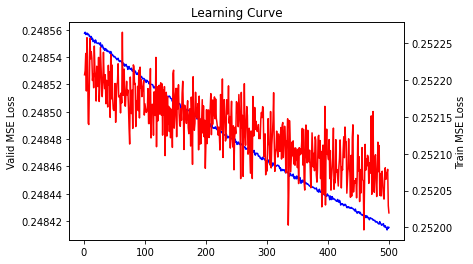

Training process takes 458.93 min.


In [29]:
sts = time.time()
learn_hist_list = []
save_path_list = []
for fold, (tr, vl) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
    print('Fold : {}'.format(fold+1))
    
    X_tr, X_val = X[tr], X[vl]
    y_tr, y_val = y[tr], y[vl]
    trn_dat = CustomDataset(X_tr, y_tr)
    val_dat = CustomDataset(X_val, y_val)
    trn_loader = DataLoader(trn_dat , batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dat , batch_size=BATCH_SIZE, shuffle=False)
    loaders = {'train':trn_loader, 'valid': val_loader}
    trained_model, learn_hist, save_path =\
        train_model(model, criterion, optimizer, scheduler, loaders, DEVICE, NUM_EPOCH, PATIANCE, \
                MDL_PATH, MDL_NAME, VER, fold+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.plot(learn_hist.epoch, learn_hist.valid_loss, color = 'blue')
    ax2 = ax1.twinx()
    plt.plot(learn_hist.epoch, learn_hist.train_loss, color = 'red')
    ax1.set_ylabel('Valid MSE Loss')
    ax2.set_ylabel('Train MSE Loss')
    plt.xlabel('Epochs')
    plt.title('Learning Curve')
    plt.show()
    learn_hist['Fold'] = fold+1
    learn_hist_list.append(learn_hist)
    save_path_list.append(save_path)
all_hist = pd.concat(learn_hist_list, axis=0)
all_hist.reset_index(inplace=True, drop=True)
all_hist.to_csv(f'{MDL_PATH}/{MDL_NAME}_{VER}/{MDL_NAME}_learning_history.csv', index=False)
ed = time.time()
print('Training process takes {:.2f} min.'.format((ed-sts)/60))

In [32]:
@njit(fastmath = True)
def utility_score_numba(date, weight, resp, action):
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / len(Pi))
    u = min(max(t, 0), 6) * np.sum(Pi)
    return u

#https://www.kaggle.com/gogo827jz/jane-street-super-fast-utility-score-function

In [33]:
model_list  = glob.glob(f'{MDL_PATH}/{MDL_NAME}_{VER}/*.pth')

In [34]:
torch.cuda.empty_cache()

In [36]:
th = 0.5
loop = int(np.round(len(X)/BATCH_SIZE))
pred_all = np.array([])
for n in tqdm(range(loop)):
    x_tt = X[BATCH_SIZE*n:BATCH_SIZE*(n+1),:]
    if np.isnan(x_tt[:, 1:].sum()):
        x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
    pred = 0.0
    X_test = torch.FloatTensor(x_tt).to(DEVICE)
    for mdl in model_list:
        load_weights = torch.load(mdl)
        model.load_state_dict(load_weights)
        model.eval()
        pred += model(X_test).cpu().detach().numpy() / FOLDS
    if len(pred_all) == 0:
        pred_all = pred.copy()
    else:
        pred_all = np.vstack([pred_all, pred]).copy()

  0%|          | 0/96 [00:00<?, ?it/s]

In [37]:
date = train['date'].values
weight = train['weight'].values
resp = train['resp'].values
train['action'] = (train['resp'] > 0).astype('int')
action_ans = train['action'].values

In [39]:
th=0.5
action = np.where(pred_all[:,0] >= th, 1, 0).astype(int).copy()
utility_score_numba(date, weight, resp, action)

3666.890810146739

In [40]:
utility_score_numba(date, weight, resp, action_ans)

173797.76047460194

In [41]:
gc.collect()

17884

## Predict Test 

In [3]:
print(f'{MDL_PATH}/{MDL_NAME}_{VER}')

../models/ae_cv_base


In [ ]:
#!kaggle datasets init -p ../models/autoencoder_test

In [9]:
%%writefile ../models/ae_cv_base/dataset-metadata.json
{
    "title": "Jane-Street",
    "id": "shinsei66/Jane-Street",
    "subtitle": "",
    "description": "",
    "isPrivate": true,
    "licenses": [
        {
            "name": "unknown" 
        }
    ],
    "keywords": [],
    "collaborators": [],
    "data": [
        {
            "description": null,
            "name": "autoencoder_99.pth",
            "totalBytes": 848,
            "columns": []
        },
        {
            "description": null,
            "name": "autoencoder_254.pth",
            "totalBytes": 856,
            "columns": []
        },
        {
            "description": null,
            "name": "mlp_base_984.pth",
            "totalBytes": 1316,
            "columns": []
        },
         {
            "description": null,
            "name": "ae_fold_1_18.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_2_428.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_3_500.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_4_199.pth",
            "totalBytes": 840,
            "columns": []
        },
        {
            "description": null,
            "name": "ae_fold_5_497.pth",
            "totalBytes": 840,
            "columns": []
        }
    ]
}

Writing ../models/ae_cv_base/dataset-metadata.json


In [ ]:
#!kaggle datasets create -p  ../models/autoencoder_early_stopping

In [7]:
!du ../models/ae_cv_base/ -a

840	../models/ae_cv_base/ae_fold_5_497.pth
76	../models/ae_cv_base/ae_learning_history.csv
840	../models/ae_cv_base/ae_fold_2_428.pth
4	../models/ae_cv_base/.ipynb_checkpoints
840	../models/ae_cv_base/ae_fold_3_500.pth
840	../models/ae_cv_base/ae_fold_4_199.pth
840	../models/ae_cv_base/ae_fold_1_18.pth
4284	../models/ae_cv_base/


In [10]:
!kaggle datasets version -p  ../models/ae_cv_base -m "auto encoder 5 fold cv baseline"

Starting upload for file ae_fold_5_497.pth
100%|████████████████████████████████████████| 836k/836k [08:47<00:00, 1.62kB/s]
Upload successful: ae_fold_5_497.pth (836KB)
Starting upload for file ae_learning_history.csv
100%|████████████████████████████████████████| 73.9k/73.9k [08:46<00:00, 144B/s]
Upload successful: ae_learning_history.csv (74KB)
Starting upload for file ae_fold_2_428.pth
100%|████████████████████████████████████████| 836k/836k [08:47<00:00, 1.62kB/s]
Upload successful: ae_fold_2_428.pth (836KB)
Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file ae_fold_3_500.pth
100%|████████████████████████████████████████| 836k/836k [08:46<00:00, 1.63kB/s]
Upload successful: ae_fold_3_500.pth (836KB)
Starting upload for file ae_fold_4_199.pth
100%|████████████████████████████████████████| 836k/836k [08:45<00:00, 1.63kB/s]
Upload successful: ae_fold_4_199.pth (836KB)
Starting upload for file ae_fold_1_18.pth
100%|█████████████████████████